In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import copy


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from keras import layers, Model, Sequential

In [4]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=4)

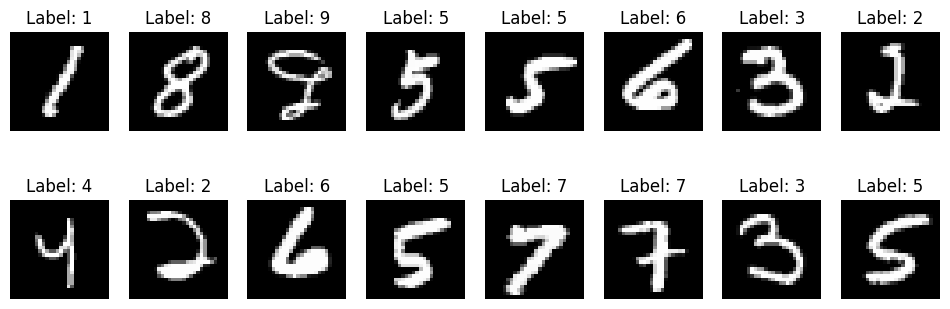

In [5]:
images_count = 0
for images, labels in train_loader:
    plt.figure(figsize=(12,4))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {labels[i].item()}')
    plt.show()
    images_count += len(images)
    if images_count >= 10:
        break


Create the autoencoder class

In [6]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(128, activation='relu', input_shape=(784,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(32,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model1 = AutoEncoder()
model1.summary()

/home/hrishikesh/Desktop/da_assignment_III/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32)             │       111,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 784)            │       112,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,496 (876.94 KB)

 Trainable params: 224,496 (876.94 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5)

In [9]:
epochs = 2000
outputs_list = []
best_model_loss = float('inf')
best_model_weights = None

patience = 3
patience_counter = 0
avg_val_loss = 0
loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}: ", end="")
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        outputs = model1(images, training=True)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Loss: {epoch_loss:.4f}")

    epoch_val_mse = 0
    
    with torch.no_grad():
        for val_images, _ in test_loader:
            val_images = val_images.view(-1, 28*28).to(device)
            val_outputs = model1(val_images, training=False)
            val_loss = loss_fn(val_outputs, val_images)
            epoch_val_mse += val_loss.item()


    avg_val_loss = epoch_val_mse / len(test_loader)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1.state_dict())
        patience_counter = 0
    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Validation Loss(MSE): {avg_val_loss:.4f}")

Epoch 1/2000: Loss: 0.0490
Validation Loss(MSE): 0.0335
Epoch 2/2000: Loss: 0.0314
Validation Loss(MSE): 0.0287
Epoch 3/2000: Loss: 0.0277
Validation Loss(MSE): 0.0263
Epoch 4/2000: Loss: 0.0253
Validation Loss(MSE): 0.0239
Epoch 5/2000: Loss: 0.0235
Validation Loss(MSE): 0.0221
Epoch 6/2000: Loss: 0.0219
Validation Loss(MSE): 0.0211
Epoch 7/2000: Loss: 0.0211
Validation Loss(MSE): 0.0205
Epoch 8/2000: Loss: 0.0205
Validation Loss(MSE): 0.0199
Epoch 9/2000: Loss: 0.0200
Validation Loss(MSE): 0.0194
Epoch 10/2000: Loss: 0.0194
Validation Loss(MSE): 0.0188
Epoch 11/2000: Loss: 0.0190
Validation Loss(MSE): 0.0186
Epoch 12/2000: Loss: 0.0186
Validation Loss(MSE): 0.0181
Epoch 13/2000: Loss: 0.0183
Validation Loss(MSE): 0.0180
Epoch 14/2000: Loss: 0.0181
Validation Loss(MSE): 0.0178
Epoch 15/2000: Loss: 0.0179
Validation Loss(MSE): 0.0178
Epoch 16/2000: Loss: 0.0178
Validation Loss(MSE): 0.0173
Epoch 17/2000: Loss: 0.0176
Validation Loss(MSE): 0.0174
Epoch 18/2000: Loss: 0.0175
Validation L

In [10]:
with torch.no_grad():
    test_mse = 0
    for test_images, _ in test_loader:
        test_images = test_images.view(-1, 28*28).to(device)
        test_outputs = model1(test_images, training=False)
        test_loss = loss_fn(test_outputs, test_images)
        test_mse += test_loss.item()

    best_model_loss = test_mse / len(test_loader)
    print(f"Mean Squared Error on Test Set: {best_model_loss:.4f}")

Mean Squared Error on Test Set: 0.0165


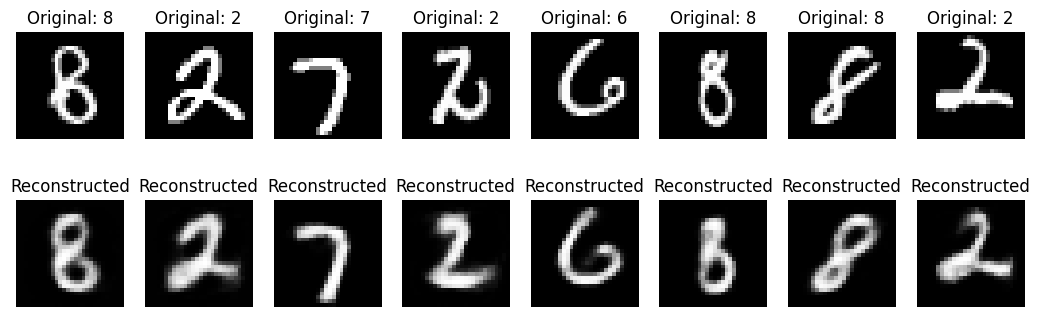

In [11]:
for images, labels in train_loader:
    plt.figure(figsize=(13, 4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Original: {labels[i].item()}')

        images_reshaped = images.view(-1, 28*28).to(device)
        with torch.no_grad():
            reconstructed = model1(images_reshaped, training=False)
        reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
    break

In [20]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(128, activation='relu', input_shape=(784,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(16,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
model2 = AutoEncoder()
model2.summary()

/home/hrishikesh/Desktop/da_assignment_III/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 16)             │       111,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 784)            │       112,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,456 (872.88 KB)

 Trainable params: 223,456 (872.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
loss_fn = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)

In [23]:
epochs = 2000
outputs_list = []
best_model_loss = float('inf')
best_model_weights = None

patience = 3
patience_counter = 0
avg_val_loss = 0
loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}: ", end="")
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer2.zero_grad()
        outputs = model2(images, training=True)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer2.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Loss: {epoch_loss:.4f}")

    epoch_val_mse = 0
    
    with torch.no_grad():
        for val_images, _ in test_loader:
            val_images = val_images.view(-1, 28*28).to(device)
            val_outputs = model2(val_images, training=False)
            val_loss = loss_fn(val_outputs, val_images)
            epoch_val_mse += val_loss.item()


    avg_val_loss = epoch_val_mse / len(test_loader)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2.state_dict())
        patience_counter = 0
    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Validation Loss(MSE): {avg_val_loss:.4f}")

Epoch 1/2000: Loss: 0.0482
Validation Loss(MSE): 0.0320
Epoch 2/2000: Loss: 0.0297
Validation Loss(MSE): 0.0276
Epoch 3/2000: Loss: 0.0273
Validation Loss(MSE): 0.0264
Epoch 4/2000: Loss: 0.0260
Validation Loss(MSE): 0.0251
Epoch 5/2000: Loss: 0.0247
Validation Loss(MSE): 0.0234
Epoch 6/2000: Loss: 0.0235
Validation Loss(MSE): 0.0226
Epoch 7/2000: Loss: 0.0225
Validation Loss(MSE): 0.0213
Epoch 8/2000: Loss: 0.0212
Validation Loss(MSE): 0.0205
Epoch 9/2000: Loss: 0.0205
Validation Loss(MSE): 0.0197
Epoch 10/2000: Loss: 0.0198
Validation Loss(MSE): 0.0192
Epoch 11/2000: Loss: 0.0192
Validation Loss(MSE): 0.0187
Epoch 12/2000: Loss: 0.0188
Validation Loss(MSE): 0.0182
Epoch 13/2000: Loss: 0.0185
Validation Loss(MSE): 0.0180
Epoch 14/2000: Loss: 0.0182
Validation Loss(MSE): 0.0178
Epoch 15/2000: Loss: 0.0180
Validation Loss(MSE): 0.0177
Epoch 16/2000: Loss: 0.0178
Validation Loss(MSE): 0.0174
Epoch 17/2000: Loss: 0.0176
Validation Loss(MSE): 0.0174
Epoch 18/2000: Loss: 0.0174
Validation L

In [24]:
with torch.no_grad():
    test_mse = 0
    for test_images, _ in test_loader:
        test_images = test_images.view(-1, 28*28).to(device)
        test_outputs = model2(test_images, training=False)
        test_loss = loss_fn(test_outputs, test_images)
        test_mse += test_loss.item()

    best_model_loss = test_mse / len(test_loader)
    print(f"Mean Squared Error on Test Set: {best_model_loss:.4f}")

Mean Squared Error on Test Set: 0.0146


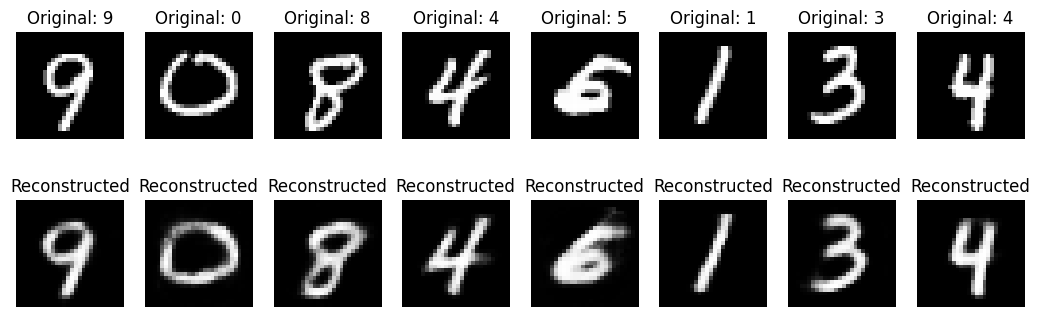

In [25]:
for images, labels in train_loader:
    plt.figure(figsize=(13, 4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Original: {labels[i].item()}')

        images_reshaped = images.view(-1, 28*28).to(device)
        with torch.no_grad():
            reconstructed = model2(images_reshaped, training=False)
        reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
    break

In [26]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(128, activation='relu', input_shape=(784,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(8, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(8,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
model3 = AutoEncoder()
model3.summary()

Model: "auto_encoder_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 8)              │       111,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 784)            │       111,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,936 (870.84 KB)

 Trainable params: 222,936 (870.84 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
loss_fn = nn.MSELoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-5)

In [29]:
epochs = 2000
outputs_list = []
best_model_loss = float('inf')
best_model_weights = None

patience = 3
patience_counter = 0
avg_val_loss = 0
loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}: ", end="")
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer3.zero_grad()
        outputs = model3(images, training=True)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer3.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Loss: {epoch_loss:.4f}")

    epoch_val_mse = 0
    
    with torch.no_grad():
        for val_images, _ in test_loader:
            val_images = val_images.view(-1, 28*28).to(device)
            val_outputs = model3(val_images, training=False)
            val_loss = loss_fn(val_outputs, val_images)
            epoch_val_mse += val_loss.item()


    avg_val_loss = epoch_val_mse / len(test_loader)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3.state_dict())
        patience_counter = 0
    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Validation Loss(MSE): {avg_val_loss:.4f}")

Epoch 1/2000: Loss: 0.0509
Validation Loss(MSE): 0.0349
Epoch 2/2000: Loss: 0.0326
Validation Loss(MSE): 0.0305
Epoch 3/2000: Loss: 0.0299
Validation Loss(MSE): 0.0289
Epoch 4/2000: Loss: 0.0286
Validation Loss(MSE): 0.0277
Epoch 5/2000: Loss: 0.0276
Validation Loss(MSE): 0.0269
Epoch 6/2000: Loss: 0.0268
Validation Loss(MSE): 0.0263
Epoch 7/2000: Loss: 0.0262
Validation Loss(MSE): 0.0259
Epoch 8/2000: Loss: 0.0258
Validation Loss(MSE): 0.0256
Epoch 9/2000: Loss: 0.0255
Validation Loss(MSE): 0.0252
Epoch 10/2000: Loss: 0.0252
Validation Loss(MSE): 0.0251
Epoch 11/2000: Loss: 0.0249
Validation Loss(MSE): 0.0244
Epoch 12/2000: Loss: 0.0247
Validation Loss(MSE): 0.0243
Epoch 13/2000: Loss: 0.0245
Validation Loss(MSE): 0.0243
Epoch 14/2000: Loss: 0.0243
Validation Loss(MSE): 0.0241
Epoch 15/2000: Loss: 0.0241
Validation Loss(MSE): 0.0241
Epoch 16/2000: Loss: 0.0240
Validation Loss(MSE): 0.0237
Epoch 17/2000: Loss: 0.0239
Validation Loss(MSE): 0.0235
Epoch 18/2000: Loss: 0.0237
Validation L

In [30]:
with torch.no_grad():
    test_mse = 0
    for test_images, _ in test_loader:
        test_images = test_images.view(-1, 28*28).to(device)
        test_outputs = model3(test_images, training=False)
        test_loss = loss_fn(test_outputs, test_images)
        test_mse += test_loss.item()

    best_model_loss = test_mse / len(test_loader)
    print(f"Mean Squared Error on Test Set: {best_model_loss:.4f}")

Mean Squared Error on Test Set: 0.0220


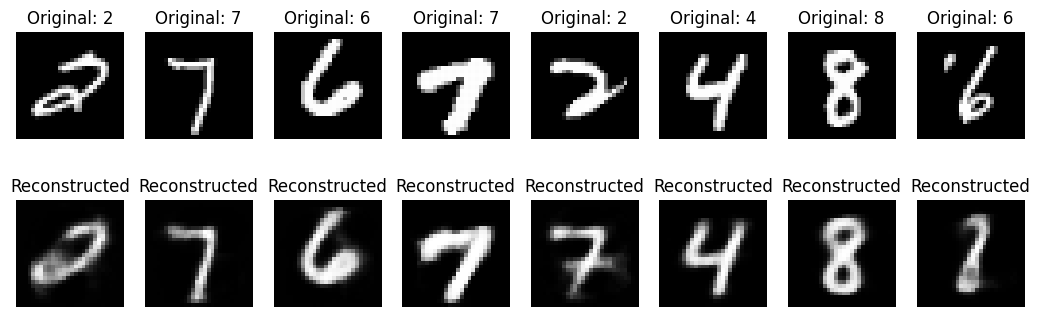

In [31]:
for images, labels in train_loader:
    plt.figure(figsize=(13, 4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Original: {labels[i].item()}')

        images_reshaped = images.view(-1, 28*28).to(device)
        with torch.no_grad():
            reconstructed = model3(images_reshaped, training=False)
        reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
    break

In [32]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(128, activation='relu', input_shape=(784,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(32,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
model4 = AutoEncoder()
model4.summary()

Model: "auto_encoder_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 32)             │       128,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 784)            │       129,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,520 (1005.94 KB)

 Trainable params: 257,520 (1005.94 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
loss_fn = nn.MSELoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-3, weight_decay=1e-5)

In [35]:
epochs = 2000
outputs_list = []
best_model_loss = float('inf')
best_model_weights = None

patience = 3
patience_counter = 0
avg_val_loss = 0
loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}: ", end="")
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer4.zero_grad()
        outputs = model4(images, training=True)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer4.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Loss: {epoch_loss:.4f}")

    epoch_val_mse = 0
    
    with torch.no_grad():
        for val_images, _ in test_loader:
            val_images = val_images.view(-1, 28*28).to(device)
            val_outputs = model4(val_images, training=False)
            val_loss = loss_fn(val_outputs, val_images)
            epoch_val_mse += val_loss.item()


    avg_val_loss = epoch_val_mse / len(test_loader)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model4.state_dict())
        patience_counter = 0
    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Validation Loss(MSE): {avg_val_loss:.4f}")

Epoch 1/2000: Loss: 0.0541
Validation Loss(MSE): 0.0384
Epoch 2/2000: Loss: 0.0338
Validation Loss(MSE): 0.0307
Epoch 3/2000: Loss: 0.0296
Validation Loss(MSE): 0.0279
Epoch 4/2000: Loss: 0.0270
Validation Loss(MSE): 0.0258
Epoch 5/2000: Loss: 0.0256
Validation Loss(MSE): 0.0251
Epoch 6/2000: Loss: 0.0248
Validation Loss(MSE): 0.0242
Epoch 7/2000: Loss: 0.0241
Validation Loss(MSE): 0.0234
Epoch 8/2000: Loss: 0.0236
Validation Loss(MSE): 0.0229
Epoch 9/2000: Loss: 0.0231
Validation Loss(MSE): 0.0228
Epoch 10/2000: Loss: 0.0227
Validation Loss(MSE): 0.0224
Epoch 11/2000: Loss: 0.0220
Validation Loss(MSE): 0.0213
Epoch 12/2000: Loss: 0.0212
Validation Loss(MSE): 0.0205
Epoch 13/2000: Loss: 0.0206
Validation Loss(MSE): 0.0200
Epoch 14/2000: Loss: 0.0202
Validation Loss(MSE): 0.0198
Epoch 15/2000: Loss: 0.0200
Validation Loss(MSE): 0.0194
Epoch 16/2000: Loss: 0.0197
Validation Loss(MSE): 0.0193
Epoch 17/2000: Loss: 0.0195
Validation Loss(MSE): 0.0190
Epoch 18/2000: Loss: 0.0192
Validation L

In [36]:
with torch.no_grad():
    test_mse = 0
    for test_images, _ in test_loader:
        test_images = test_images.view(-1, 28*28).to(device)
        test_outputs = model4(test_images, training=False)
        test_loss = loss_fn(test_outputs, test_images)
        test_mse += test_loss.item()

    best_model_loss = test_mse / len(test_loader)
    print(f"Mean Squared Error on Test Set: {best_model_loss:.4f}")

Mean Squared Error on Test Set: 0.0175


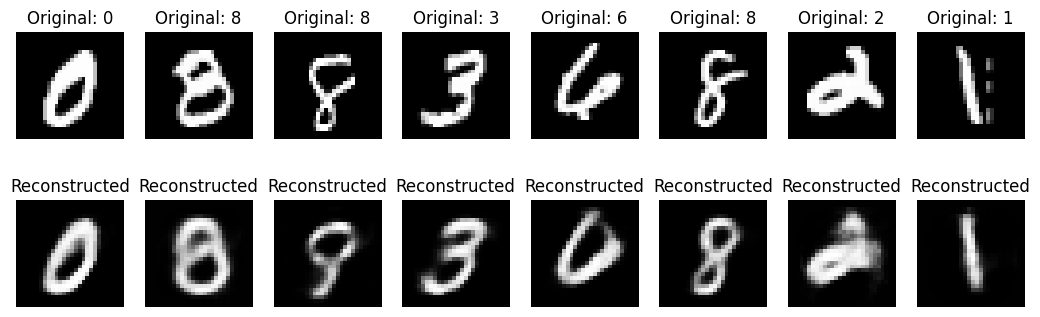

In [37]:
for images, labels in train_loader:
    plt.figure(figsize=(13, 4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Original: {labels[i].item()}')

        images_reshaped = images.view(-1, 28*28).to(device)
        with torch.no_grad():
            reconstructed = model4(images_reshaped, training=False)
        reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
    break

In [38]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(64, activation='relu', input_shape=(784,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(32,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:
model5 = AutoEncoder()
model5.summary()

Model: "auto_encoder_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 32)             │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 784)            │        54,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,504 (419.94 KB)

 Trainable params: 107,504 (419.94 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
loss_fn = nn.MSELoss()
optimizer5 = torch.optim.Adam(model5.parameters(), lr=1e-3, weight_decay=1e-5)

In [41]:
epochs = 2000
outputs_list = []
best_model_loss = float('inf')
best_model_weights = None

patience = 3
patience_counter = 0
avg_val_loss = 0
loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}: ", end="")
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer5.zero_grad()
        outputs = model5(images, training=True)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer5.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Loss: {epoch_loss:.4f}")

    epoch_val_mse = 0
    
    with torch.no_grad():
        for val_images, _ in test_loader:
            val_images = val_images.view(-1, 28*28).to(device)
            val_outputs = model5(val_images, training=False)
            val_loss = loss_fn(val_outputs, val_images)
            epoch_val_mse += val_loss.item()


    avg_val_loss = epoch_val_mse / len(test_loader)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model5.state_dict())
        patience_counter = 0
    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Validation Loss(MSE): {avg_val_loss:.4f}")

Epoch 1/2000: Loss: 0.0471
Validation Loss(MSE): 0.0306
Epoch 2/2000: Loss: 0.0276
Validation Loss(MSE): 0.0243
Epoch 3/2000: Loss: 0.0228
Validation Loss(MSE): 0.0214
Epoch 4/2000: Loss: 0.0211
Validation Loss(MSE): 0.0201
Epoch 5/2000: Loss: 0.0200
Validation Loss(MSE): 0.0189
Epoch 6/2000: Loss: 0.0190
Validation Loss(MSE): 0.0181
Epoch 7/2000: Loss: 0.0183
Validation Loss(MSE): 0.0177
Epoch 8/2000: Loss: 0.0177
Validation Loss(MSE): 0.0171
Epoch 9/2000: Loss: 0.0173
Validation Loss(MSE): 0.0167
Epoch 10/2000: Loss: 0.0169
Validation Loss(MSE): 0.0164
Epoch 11/2000: Loss: 0.0165
Validation Loss(MSE): 0.0158
Epoch 12/2000: Loss: 0.0161
Validation Loss(MSE): 0.0157
Epoch 13/2000: Loss: 0.0158
Validation Loss(MSE): 0.0152
Epoch 14/2000: Loss: 0.0156
Validation Loss(MSE): 0.0152
Epoch 15/2000: Loss: 0.0154
Validation Loss(MSE): 0.0149
Epoch 16/2000: Loss: 0.0152
Validation Loss(MSE): 0.0149
Epoch 17/2000: Loss: 0.0150
Validation Loss(MSE): 0.0147
Epoch 18/2000: Loss: 0.0149
Validation L

In [42]:
with torch.no_grad():
    test_mse = 0
    for test_images, _ in test_loader:
        test_images = test_images.view(-1, 28*28).to(device)
        test_outputs = model5(test_images, training=False)
        test_loss = loss_fn(test_outputs, test_images)
        test_mse += test_loss.item()

    best_model_loss = test_mse / len(test_loader)
    print(f"Mean Squared Error on Test Set: {best_model_loss:.4f}")

Mean Squared Error on Test Set: 0.0118


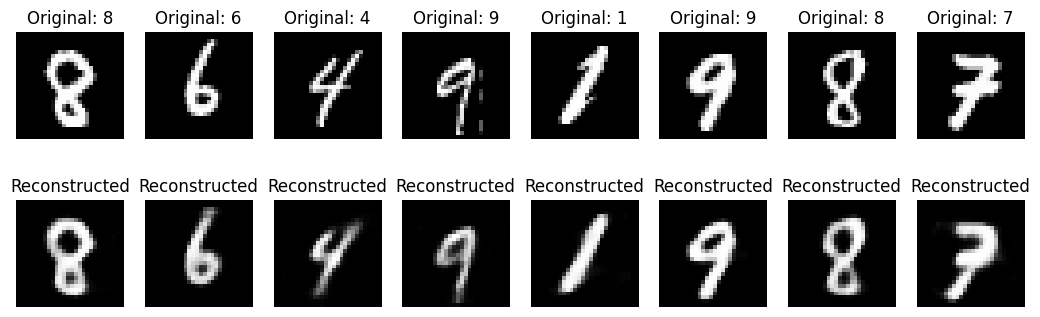

In [43]:
for images, labels in train_loader:
    plt.figure(figsize=(13, 4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Original: {labels[i].item()}')

        images_reshaped = images.view(-1, 28*28).to(device)
        with torch.no_grad():
            reconstructed = model5(images_reshaped, training=False)
        reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
    break

In [53]:
print("Comparing the MSE of all models:")
with torch.no_grad():
    for i, model in enumerate([model1, model2, model3, model4, model5], start=1):
        test_mse = 0
        for test_images, _ in test_loader:
            test_images = test_images.view(-1, 28*28).to(device)
            test_outputs = model(test_images, training=False)
            test_loss = loss_fn(test_outputs, test_images)
            test_mse += test_loss.item()

        model_loss = test_mse / len(test_loader)
        print(f"Model {i} with encoder/decoder layers {len(model.encoder.layers)}/{len(model.decoder.layers)} and latent space/bottleneck size = {model.encoder.layers[-1].units} - Mean Squared Error on Test Set: {model_loss:.4f}")

Comparing the MSE of all models:
Model 1 with encoder/decoder layers 4/4 and latent space/bottleneck size = 32 - Mean Squared Error on Test Set: 0.0165
Model 2 with encoder/decoder layers 4/4 and latent space/bottleneck size = 16 - Mean Squared Error on Test Set: 0.0146
Model 3 with encoder/decoder layers 4/4 and latent space/bottleneck size = 8 - Mean Squared Error on Test Set: 0.0220
Model 4 with encoder/decoder layers 5/5 and latent space/bottleneck size = 32 - Mean Squared Error on Test Set: 0.0175
Model 5 with encoder/decoder layers 3/3 and latent space/bottleneck size = 32 - Mean Squared Error on Test Set: 0.0118
